## Predicting Graduation Rates for Public High Schools
**This notebook explores predicting graduation rates for public high schools in North Carolina.** 
* Public school student body racial compositions are also considered when making predictions in this notebook.
* The North Carolina Educational Attainment Data Repository for Machine Learning is located on Github at: https://github.com/jakemdrew/EducationDataNC 

**For documentation on various Generalized Linear Models in Sklearn see:**
* http://scikit-learn.org/stable/modules/linear_model.html
* https://stackoverflow.com/questions/33845539/modelling-probabilities-in-a-regularized-logistic-regression-model-in-python

In [1]:
#import required Libraries
import pandas as pd
import numpy as np

#Read in the high schools dataset - NC EA Public High Schools Dataset Feb 2018

#The 'path' variable may also be a URL pointing to the proper raw file path on github: 
#path="https://raw.githubusercontent.com/jakemdrew/EducationDataNC/master/2018/Machine%20Learning%20Datasets/PublicHighSchools2018_ML.csv"

path="C:/Users/Jake/Documents/GitHub/EducationDataNC/2018/Machine Learning Datasets/PublicHighSchools2018_ML.csv"
schData=pd.read_csv(path, low_memory=False, dtype={'agency_code': object})

#inspect data 
schData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 603 entries, 0 to 602
Columns: 639 entries, AsianPct to agency_code
dtypes: float64(377), int64(261), object(1)
memory usage: 2.9+ MB


In [2]:
#Get 4 year graduation rates from the public school file. 
#4yr was removed from the ML file for correlation > 95% with other graduation rate fields
path="C:/Users/Jake/Documents/GitHub/EducationDataNC/2018/School Datasets/PublicHighSchools2018.csv"
schDataALL=pd.read_csv(path, low_memory=False, dtype={'agency_code': object})

schDataALL=schDataALL[['agency_code','pct_STD_ALL_CGR']]

schData=schData.merge(schDataALL,how='left',on='agency_code', suffixes=('', '_Drop'))

print("Check ML file after adding pct_STD_ALL_CGR:")
print("*******************************************")
schData.info()

Check ML file after adding pct_STD_ALL_CGR:
*******************************************
<class 'pandas.core.frame.DataFrame'>
Int64Index: 603 entries, 0 to 602
Columns: 640 entries, AsianPct to pct_STD_ALL_CGR
dtypes: float64(378), int64(261), object(1)
memory usage: 2.9+ MB


In [3]:
# Remove any columns from the model's training data that are directly related to the graduation rate. 
GradRateCols = schData.columns[schData.columns.str.lower().str.contains('graduation') |
                               schData.columns.str.lower().str.contains('_cgr') |
                               schData.columns.str.lower().str.contains('cgr_') |
                               schData.columns.str.lower().str.contains('_cgrs') |
                               schData.columns.str.lower().str.contains('cgrs_') ]
GradRateCols

Index(['pct_EXT_AIG_CGR', 'pct_EXT_ALL_CGR', 'pct_EXT_BL7_CGR',
       'pct_EXT_EDS_CGR', 'pct_EXT_FEM_CGR', 'pct_EXT_HI7_CGR',
       'pct_EXT_MALE_CGR', 'pct_EXT_SWD_CGR', 'pct_EXT_WH7_CGR',
       'pct_STD_AIG_CGR', 'pct_STD_BL7_CGR', 'pct_STD_EDS_CGR',
       'pct_STD_FEM_CGR', 'pct_STD_HI7_CGR', 'pct_STD_MALE_CGR',
       'pct_STD_SWD_CGR', 'pct_STD_WH7_CGR',
       'pct_met_4 Year Graduation Rate_LTG', 'cgrs_score',
       'cgrs_score_ALL_SPG2', 'cgrs_score_BL7_SPG2', 'cgrs_score_EDS_SPG2',
       'cgrs_score_WH7_SPG2',
       'target_list_4 Year Graduation Rate,EL Progress,Math Grade 11,Math Grades 3-8,Reading Grade 10,Reading Grades 3-8',
       'target_list_4 Year Graduation Rate,EL Progress,Math Grade 11,Reading Grade 10',
       'target_list_4 Year Graduation Rate,Math Grade 11',
       'target_list_4 Year Graduation Rate,Math Grade 11,Math Grades 3-8,Reading Grade 10,Reading Grades 3-8',
       'target_list_4 Year Graduation Rate,Math Grade 11,Math Grades 3-8,Reading Grades

### This model only considers public high schools which are reporting both a 4 and 5 year graduation rate. 

In [5]:
#Remove schools with graduation rates == 0 from the model
schData = schData[schData['pct_STD_ALL_CGR'] > 0]
schData = schData[schData['pct_EXT_ALL_CGR'] > 0]
schData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 536 entries, 0 to 602
Columns: 640 entries, AsianPct to pct_STD_ALL_CGR
dtypes: float64(378), int64(261), object(1)
memory usage: 2.6+ MB


In [6]:
# create x explanatory and y response variables for regression
Y_4yr_Gr = schData['pct_STD_ALL_CGR']
Y_5yr_Gr = schData['pct_EXT_ALL_CGR']

#Delete the response variable and other graduation rate data columns from our training dataset
X_highSchools = schData.drop(GradRateCols, axis=1)

Y = Y_4yr_Gr

#inspect data 
X_highSchools.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 536 entries, 0 to 602
Columns: 608 entries, AsianPct to agency_code
dtypes: float64(354), int64(253), object(1)
memory usage: 2.5+ MB


## Cross Validation
**Cross validation is performed using repeated holdout using ShuffleSplit()**
* Ten folds are used
* The split is: 90% training data and 10% test data
* A random seed is set so the same random test and training splits are used each time cross validation is performed.

In [7]:
#Divide data into test and training splits
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=10, test_size=0.10, random_state=0)

## Custom Scorers for Evaluating Regression Models 

**All regression models created in this notebook are validated using the following metrics:**
* Mean Absolute Error (MAE)
* Root Mean Squared Error (RMSE) - https://stackoverflow.com/questions/17197492/root-mean-square-error-in-python
* Mean Absolute Percentage Error (MAPE) - https://stackoverflow.com/questions/42250958/how-to-optimize-mape-code-in-python

**For details on making scorers to return multiple mean error scores see:**
* http://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html
* https://github.com/scikit-learn/scikit-learn/pull/7388
* https://github.com/drorata/multiscorer

In [8]:
#Use mean absolute error (MAE) to score the regression models created 
#(the scale of MAE is identical to the response variable)
from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error

#Function for Root mean squared error
#https://stackoverflow.com/questions/17197492/root-mean-square-error-in-python
def rmse(y_actual, y_predicted):
    return np.sqrt(mean_squared_error(y_actual, y_predicted))

#Function for Mean Absolute Percentage Error (MAPE) - Untested
#Adapted from - https://stackoverflow.com/questions/42250958/how-to-optimize-mape-code-in-python
def mape(y_actual, y_predicted): 
    mask = y_actual != 0
    return (np.fabs(y_actual - y_predicted)/y_actual)[mask].mean() * 100

#Create scorers for rmse and mape functions
mae_scorer = make_scorer(score_func=mean_absolute_error, greater_is_better=False)
rmse_scorer = make_scorer(score_func=rmse, greater_is_better=False)
mape_scorer = make_scorer(score_func=mape, greater_is_better=False)

#Make scorer array to pass into cross_validate() function for producing mutiple scores for each cv fold.
errorScoring = {'MAE':  mae_scorer, 
                'RMSE': rmse_scorer,
                'MAPE': mape_scorer
               } 

## Regression Model Evaluation
** All regression models are evaluated using the regression model evaluation function below: ** 
* The following regression evaluation function uses the cross validation object and the custom scorers in the two cells above in combination with sklearn.model_selection's cross_validate function to perform cross validation for regression estimators.
* The cross validation object above uses a random seed to ensure that all regression estimators are tested on the same randomly selected records for each cross validation fold.
* Custom scorers are created using the three chosen mean error scores and passed into cross_validate(), so all three scores are calcualted using a single call to cross_validate().
* All of this functionality is wrapped within the custom EvaluateRegressionEstimator() function below so multiple regression models may be tested using the same test / train cv data and evaluation scores producing a consistent output for each model without the need to re-write the same code over and over. 

In [12]:
from sklearn.model_selection import cross_validate

def EvaluateRegressionEstimator(regEstimator, X, y, cv):
    
    scores = cross_validate(regEstimator, X, y, scoring=errorScoring, cv=cv, return_train_score=True)

    #cross val score sign-flips the outputs of MAE
    # https://github.com/scikit-learn/scikit-learn/issues/2439
    scores['test_MAE'] = scores['test_MAE'] * -1
    scores['test_MAPE'] = scores['test_MAPE'] * -1
    scores['test_RMSE'] = scores['test_RMSE'] * -1

    #print mean MAE for all folds 
    maeAvg = scores['test_MAE'].mean()
    print_str = "The average MAE for all cv folds is: \t\t\t {maeAvg:.5}"
    print(print_str.format(maeAvg=maeAvg))

    #print mean test_MAPE for all folds
    scores['test_MAPE'] = scores['test_MAPE']
    mape_avg = scores['test_MAPE'].mean()
    print_str = "The average MAE percentage (MAPE) for all cv folds is: \t {mape_avg:.5}"
    print(print_str.format(mape_avg=mape_avg))

    #print mean MAE for all folds 
    RMSEavg = scores['test_RMSE'].mean()
    print_str = "The average RMSE for all cv folds is: \t\t\t {RMSEavg:.5}"
    print(print_str.format(RMSEavg=RMSEavg))
    print('*********************************************************')

    print('Cross Validation Fold Mean Error Scores')
    scoresResults = pd.DataFrame()
    scoresResults['MAE'] = scores['test_MAE']
    scoresResults['MAPE'] = scores['test_MAPE']
    scoresResults['RMSE'] = scores['test_RMSE']
    return scoresResults


## Modifying or Making Custom Estimators

**Linear Regression is used to create a baseline model here.  Since linear regression may predict response variable values outside the range of the training data's response variable, we create a custom linear regression estimator with graduation rate predictions clipped between 0% and 100%.** 

**For more details see:**
* http://scikit-learn.org/stable/developers/contributing.html#rolling-your-own-estimator 
* https://github.com/scikit-learn/scikit-learn/issues/6950
* http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
* https://github.com/scikit-learn-contrib/project-template/blob/master/skltemplate/template.py
* https://stackoverflow.com/questions/44234682/how-to-use-sklearn-when-target-variable-is-a-proportion

In [24]:
#Make new estimator compatible for use with GridSearchCV() and cross_validate()
# -  Cap predict function for LinearRegression between 0 and 100
# -  See: Roll your own estimator links above for details. 
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import LinearRegression

class CappedLinearRegression(LinearRegression):

    def predict(self, X):
        return np.clip(super(CappedLinearRegression, self).predict(X), 0, 100) 

### Linear Regression Grid Search
** Here we perform a grid search testing 40 models to find the best parameters for our Linear Regression model based on Mean Absolute Error.  See more on parameter tuning with grid search here:**
* http://scikit-learn.org/stable/modules/grid_search.html

In [25]:
#Create a Linear Regression object and perform a grid search to find the best parameters
linreg = CappedLinearRegression()
parameters = {'normalize':(True,False), 'fit_intercept':(True,False)}

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=linreg
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_highSchools, Y)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    3.4s finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.1, train_size=None),
       error_score='raise-deprecating',
       estimator=CappedLinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
            normalize=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'normalize': (True, False), 'fit_intercept': (True, False)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_absolute_error, greater_is_better=False),
       verbose=1)

In [26]:
#Print the parameterization of the best estimator
regGridSearch.best_estimator_

CappedLinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
            normalize=True)

## Baseline Regression Model - Cross Validation
**Perform tenfold cross validation using the grid search "best" parameters and our Capped Linear Regression estimator**
* 10-fold cross-validation using the parameters for the top performing model 
* CAP predictions between 0 and 100% 
* Evaluate cross-validation results using MAE, MAPE, and RMSE

In [27]:
#Create CappedLinearRegression predictions between 0 and 100% using the best parameters for our Linear Regression object
regEstimator = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateRegressionEstimator(regEstimator, X_highSchools, Y, cv)


The average MAE for all cv folds is: 			 11.864
The average MAE percentage (MAPE) for all cv folds is: 	 19.877
The average RMSE for all cv folds is: 			 17.365
*********************************************************
Cross Validation Fold Mean Error Scores


,MAE,MAPE,RMSE
0,11.160201,13.715467,16.940213
1,13.252552,22.070585,20.201376
2,13.280939,17.776753,19.542977
3,9.435834,13.218761,13.872872
4,13.143821,16.108767,17.833189
5,12.056523,16.482314,17.415171
6,8.857411,21.138153,12.067560
7,12.185528,14.843477,17.838612
8,13.346722,28.294134,19.384689
9,11.920470,35.120694,18.555962


## Support Vector Regression
**This model uses Support Vector Machines for regression of continuous variables (SVR). Please see documentation here:"**
* http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html
* http://scikit-learn.org/stable/modules/svm.html

In [60]:
#Create a Linear regression object and perform a grid search to find the best parameters
from sklearn.svm import SVR
reg = SVR()

#Set up SVR parameters to test (WARNING: Creates 80 models!!!) 
costs = [0.001, 0.1]
defGamma = 1 / X_highSchools.shape[1]  #This is the default value for the gamma parameter
gammas = [defGamma, 0.1]
kernels = ['rbf','linear']
parameters = {'C': costs, 'gamma' : gammas, 'kernel': kernels}

#Create a grid search object using the parameters above
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=reg
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_highSchools, Y)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed: 87.2min
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed: 306.8min finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.1, train_size=None),
       error_score='raise-deprecating',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=8,
       param_grid={'C': [0.001, 0.1], 'gamma': [0.0016313213703099511, 0.1], 'kernel': ['rbf', 'linear']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_absolute_error, greater_is_better=False),
       verbose=1)

In [61]:
#Display the best estimator parameters
regGridSearch.best_estimator_

SVR(C=0.001, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma=0.0016313213703099511, kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

In [28]:
from sklearn.svm import SVR

#Create a regression estimator with best parameters for cross validation
regEstimator = SVR(C=0.001, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
                   gamma=0.0016313213703099511, kernel='rbf', max_iter=-1, shrinking=True,
                   tol=0.001, verbose=False)

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
EvaluateRegressionEstimator(regEstimator, X_highSchools, Y, cv)

The average MAE for all cv folds is: 			 8.4487
The average MAE percentage (MAPE) for all cv folds is: 	 24.946
The average RMSE for all cv folds is: 			 13.804
*********************************************************
Cross Validation Fold Mean Error Scores


,MAE,MAPE,RMSE
0,7.675926,10.012086,10.242068
1,8.474074,41.117028,15.886227
2,8.546315,12.578250,12.771193
3,8.255389,13.680975,13.413115
4,7.600019,10.128867,10.502447
5,7.970370,12.612069,12.548454
6,10.244519,73.994533,20.315463
7,6.898056,9.083452,9.821015
8,11.322296,27.515239,18.209379
9,7.499981,38.738319,14.330399


In [29]:
#Do we predict graduation rates greater than 100%?
regEstimator = SVR(C=0.001, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
                   gamma=0.0016313213703099511, kernel='rbf', max_iter=-1, shrinking=True,
                   tol=0.001, verbose=False)

regEstimator.fit(X_highSchools, Y)
yhat = regEstimator.predict(X_highSchools)
print("Yhat Max: ", yhat.max())

Yhat Max:  88.50150000000001


## Graduation Rate - Lasso Regression
**This model uses Lasso regression (L1 Norm). Please see documentation here:"**
* **Caution!** - See documentation for fit_intercept, normalize, and copy_X. Lasso can over-write your X data!
* Lasso may also perform scaling as well.  Please see docs!
* http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

In [64]:
#Create a regression object and perform a grid search to find the best parameters
from sklearn.linear_model import Lasso

reg = Lasso(fit_intercept=True, normalize=True,copy_X=True
          , max_iter=10000, precompute=True, tol=0.0001, random_state=0)

#Test parameters 
alpha = [0.001, 0.1, 1, 10, 20]
selection = ['cyclic','random']
warm_start = [True, False]
parameters = {'alpha': alpha, 'selection': selection, 'warm_start': warm_start}

#Create a grid search object using the parameters above
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=reg
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_highSchools, Y)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.6s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   10.6s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:   10.9s finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.1, train_size=None),
       error_score='raise-deprecating',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=True, positive=False, precompute=True, random_state=0,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=8,
       param_grid={'alpha': [0.001, 0.1, 1, 10, 20], 'selection': ['cyclic', 'random'], 'warm_start': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_absolute_error, greater_is_better=False),
       verbose=1)

In [65]:
#Display the best estimator parameters
regGridSearch.best_estimator_

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=True, positive=False, precompute=True, random_state=0,
   selection='cyclic', tol=0.0001, warm_start=True)

In [31]:
from sklearn.linear_model import Lasso

#Create a regression estimator with best parameters for cross validation
regEstimator = Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=10000,
                     normalize=True, positive=False, precompute=True, random_state=0,
                     selection='cyclic', tol=0.0001, warm_start=True)

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
EvaluateRegressionEstimator(regEstimator, X_highSchools, Y, cv)

The average MAE for all cv folds is: 			 4.8915
The average MAE percentage (MAPE) for all cv folds is: 	 11.125
The average RMSE for all cv folds is: 			 7.7657
*********************************************************
Cross Validation Fold Mean Error Scores


,MAE,MAPE,RMSE
0,3.938741,5.074130,5.673482
1,6.443190,16.353963,10.024857
2,4.954757,6.610556,7.827504
3,3.919176,5.908358,6.034645
4,4.243233,5.373732,5.434744
5,5.449490,7.692975,8.450277
6,5.223369,28.373057,10.150536
7,5.032247,6.064938,7.464032
8,5.196559,13.742380,9.193858
9,4.514683,16.058614,7.403092


In [32]:
#Do we predict graduation rates greater than 100%?
regEstimator = Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=10000,
                     normalize=True, positive=False, precompute=True, random_state=0,
                     selection='cyclic', tol=0.0001, warm_start=True)

regEstimator.fit(X_highSchools, Y)
yhat = regEstimator.predict(X_highSchools)
print("Yhat Max: ", yhat.max())

Yhat Max:  95.5050078743451


## Ridge Regression
**This model uses Ridge regression (L2 Norm). Please see documentation here:"**
* http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

In [34]:
#Create a regression object and perform a grid search to find the best parameters
from sklearn.linear_model import Ridge

reg = Ridge(fit_intercept=True, normalize=True,copy_X=True
          , max_iter=1000, tol=0.0001, random_state=0)

#Test parameters 
alpha = [0.001, 0.1, 1, 5, 10, 20]
solver = [ 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
parameters = {'alpha': alpha, 'solver': solver}

#Create a grid search object using the parameters above
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=reg
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_highSchools, Y)

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.4s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   28.4s
[Parallel(n_jobs=8)]: Done 360 out of 360 | elapsed:   33.4s finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.1, train_size=None),
       error_score='raise-deprecating',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, random_state=0, solver='auto', tol=0.0001),
       fit_params=None, iid='warn', n_jobs=8,
       param_grid={'alpha': [0.001, 0.1, 1, 5, 10, 20], 'solver': ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_absolute_error, greater_is_better=False),
       verbose=1)

In [35]:
#Display the best estimator parameters
regGridSearch.best_estimator_

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
   random_state=0, solver='svd', tol=0.0001)

In [36]:
#Create a regression estimator with best parameters for cross validation
regEstimator = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
EvaluateRegressionEstimator(regEstimator, X_highSchools, Y, cv)

The average MAE for all cv folds is: 			 5.3858
The average MAE percentage (MAPE) for all cv folds is: 	 11.828
The average RMSE for all cv folds is: 			 8.4452
*********************************************************
Cross Validation Fold Mean Error Scores


,MAE,MAPE,RMSE
0,4.559282,5.722364,6.562002
1,6.821794,16.732035,10.308633
2,4.933653,6.415271,7.775474
3,4.563335,6.131716,6.683638
4,4.155343,5.007036,5.594813
5,6.951969,10.103231,11.089799
6,5.100118,30.957213,9.404295
7,5.620008,6.657565,9.139963
8,5.484358,12.895808,8.915608
9,5.668196,17.655651,8.977631


In [37]:
#Do we predict graduation rates greater than 100%?
regEstimator = regGridSearch.best_estimator_

regEstimator.fit(X_highSchools, Y)
yhat = regEstimator.predict(X_highSchools)
print("Yhat Max: ", yhat.max())

Yhat Max:  100.82452049849329


## Elastic Net Regression
**This model uses Elastic Net Regression (L1 and L2 Norm mixing). Please see documentation here:"**
* http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html

In [38]:
#Create a regression object and perform a grid search to find the best parameters
from sklearn.linear_model import ElasticNet

reg = ElasticNet(fit_intercept=True, normalize=True, precompute=True, copy_X=True
          , max_iter=10000, tol=0.0001, random_state=0)
 
#Test parameters
l1_ratio = [0.001, 0.01, 0.1, 0.5, 0.75, 1]
alpha = [0.001, 0.1, 1, 10]
selection = ['cyclic','random']
warm_start = [True, False]
parameters = {'l1_ratio': l1_ratio, 'alpha': alpha, 'selection': selection, 'warm_start': warm_start}

#Create a grid search object using the parameters above
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=reg
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_highSchools, Y)

Fitting 10 folds for each of 96 candidates, totalling 960 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   21.4s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   30.5s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:   38.9s
[Parallel(n_jobs=8)]: Done 960 out of 960 | elapsed:   42.9s finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.1, train_size=None),
       error_score='raise-deprecating',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=10000, normalize=True, positive=False, precompute=True,
      random_state=0, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=8,
       param_grid={'l1_ratio': [0.001, 0.01, 0.1, 0.5, 0.75, 1], 'alpha': [0.001, 0.1, 1, 10], 'selection': ['cyclic', 'random'], 'warm_start': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_absolute_error, greater_is_better=False),
       verbose=1)

In [39]:
#Display the best estimator parameters
regGridSearch.best_estimator_

ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=1,
      max_iter=10000, normalize=True, positive=False, precompute=True,
      random_state=0, selection='random', tol=0.0001, warm_start=True)

In [40]:
#Create a regression estimator with best parameters for cross validation
regEstimator = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
EvaluateRegressionEstimator(regEstimator, X_highSchools, Y, cv)

The average MAE for all cv folds is: 			 4.8908
The average MAE percentage (MAPE) for all cv folds is: 	 11.124
The average RMSE for all cv folds is: 			 7.7642
*********************************************************
Cross Validation Fold Mean Error Scores


,MAE,MAPE,RMSE
0,3.937957,5.073328,5.673693
1,6.442637,16.352083,10.023126
2,4.952152,6.605203,7.821276
3,3.920452,5.909554,6.032423
4,4.241561,5.372037,5.432706
5,5.449684,7.692945,8.449574
6,5.222069,28.373343,10.149818
7,5.031768,6.063995,7.462546
8,5.195722,13.740614,9.193469
9,4.514205,16.059373,7.402930


In [41]:
#Do we predict graduation rates greater than 100%?
regEstimator =  regGridSearch.best_estimator_

regEstimator.fit(X_highSchools, Y)
yhat = regEstimator.predict(X_highSchools)
print("Yhat Max: ", yhat.max())

Yhat Max:  95.50569622560306


## Regression using the Random Forest Regressor 
**This model uses a custom Logit model using the Random Forest Regressor. Please see documentation here: **
* http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor
* https://www.analyticsvidhya.com/blog/2015/06/tuning-random-forest-model/
* https://www.kaggle.com/general/4092

In [75]:
#Create a Linear Regression object and perform a grid search to find the best parameters
from sklearn.ensemble import RandomForestRegressor

linreg = RandomForestRegressor()
parameters = { 'min_samples_split':[2,3,4,5]
              ,'n_estimators' : [500]
              ,'min_samples_leaf': [10, 25, 50]
              ,'criterion': ['mae']
              ,'n_jobs':[8] 
              ,'random_state': [0]
             }

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=linreg
                   , n_jobs=8 
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_highSchools, Y)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed: 16.6min
[Parallel(n_jobs=8)]: Done 120 out of 120 | elapsed: 35.4min finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.1, train_size=None),
       error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=8,
       param_grid={'min_samples_split': [2, 3, 4, 5], 'n_estimators': [500], 'min_samples_leaf': [10, 25, 50], 'criterion': ['mae'], 'n_jobs': [8], 'random_state': [0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_absolute_error, greater_is_better=False),
       verbose=1)

In [76]:
#Display the best estimator parameters
regGridSearch.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=25, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=8,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [77]:
regEstimator = RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=25, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=8,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateRegressionEstimator(regEstimator, X_highSchools, Y, cv)

The average MAE for all cv folds is: 			 4.5672
The average MAE percentage (MAPE) for all cv folds is: 	 14.218
The average RMSE for all cv folds is: 			 8.2166
*********************************************************
Cross Validation Fold Mean Error Scores


,MAE,MAPE,RMSE
0,3.259081,4.216215,5.040674
1,6.437228,26.553875,12.042380
2,4.016654,5.456181,6.503988
3,4.133141,6.430898,6.682765
4,3.247300,4.078971,4.406723
5,5.413031,7.934487,9.394775
6,5.721611,46.024083,12.202571
7,4.190207,5.152883,7.937173
8,5.002378,13.250361,9.211104
9,4.251294,23.078166,8.743986


In [78]:
#Do we predict graduation rates greater than 100%?
regEstimator = RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=25, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=8,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

regEstimator.fit(X_highSchools, Y)
yhat = regEstimator.predict(X_highSchools)
print("Yhat Max: ", yhat.max())

Yhat Max:  95.0


## Regression using the Extra Trees Regressor 
**This model uses a custom Logit model using the Random Forest Regressor. Please see documentation here: **
* http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html

In [9]:
#Create a Linear Regression object and perform a grid search to find the best parameters
from sklearn.ensemble import ExtraTreesRegressor

linreg = ExtraTreesRegressor()
parameters = { 'min_samples_split':[2,3,4,5]
              ,'n_estimators' : [500]
              ,'min_samples_leaf': [10, 25, 50]
              ,'criterion': ['mae']
              ,'n_jobs':[8] 
              ,'random_state': [0]
             }

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=linreg
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_highSchools, Y)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  9.7min
[Parallel(n_jobs=8)]: Done 120 out of 120 | elapsed: 19.8min finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.1, train_size=None),
       error_score='raise-deprecating',
       estimator=ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
          oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=8,
       param_grid={'min_samples_split': [2, 3, 4, 5], 'n_estimators': [500], 'min_samples_leaf': [10, 25, 50], 'criterion': ['mae'], 'n_jobs': [8], 'random_state': [0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_absolute_error, greater_is_better=False),
       verbose=1)

In [13]:
#Display the best estimator parameters
regGridSearch.best_estimator_

ExtraTreesRegressor(bootstrap=False, criterion='mae', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=25, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=8,
          oob_score=False, random_state=0, verbose=0, warm_start=False)

In [14]:
from sklearn.ensemble import ExtraTreesRegressor

#Create CappedLinearRegression predictions between 0 and 100% using the best parameters for our Linear Regression object
regEstimator = ExtraTreesRegressor(bootstrap=False, criterion='mae', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=10, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=8,
          oob_score=False, random_state=0, verbose=0, warm_start=False)

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateRegressionEstimator(regEstimator, X_highSchools, Y, cv)

The average MAE for all cv folds is: 			 4.7414
The average MAE percentage (MAPE) for all cv folds is: 	 11.869
The average RMSE for all cv folds is: 			 9.0968
*********************************************************
Cross Validation Fold Mean Error Scores


,MAE,MAPE,RMSE
0,4.533613,6.188370,9.820520
1,6.087533,13.866803,11.224118
2,4.910267,6.693758,9.418293
3,4.297085,6.530385,7.162960
4,3.660500,4.758730,6.517192
5,5.767494,7.932863,10.835884
6,4.500280,37.113224,9.758154
7,4.515439,5.557012,9.823689
8,4.343585,10.991885,7.708154
9,4.798543,19.060000,8.699373


In [15]:
#Do we predict graduation rates greater than 100%?
regEstimator = ExtraTreesRegressor(bootstrap=False, criterion='mae', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=10, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=8,
          oob_score=False, random_state=0, verbose=0, warm_start=False)

regEstimator.fit(X_highSchools, Y)
yhat = regEstimator.predict(X_highSchools)
print("Yhat Max: ", yhat.max())

Yhat Max:  95.0


## Multilayer Perceptron Regression 
**This model uses a neural network for regression. Please see documentation here: **
* http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html
* https://stackoverflow.com/questions/41069905/trouble-fitting-simple-data-with-mlpregressor

In [16]:
#Create a Linear Regression object and perform a grid search to find the best parameters
from sklearn.neural_network import MLPRegressor

linreg = MLPRegressor()
parameters = { 'activation':['logistic']
              ,'hidden_layer_sizes' : [200]
              ,'solver': ['sgd','adam']
              ,'alpha': [0.001]
              ,'batch_size':['auto'] 
              ,'random_state': [0]
              ,'learning_rate': ['constant', 'invscaling', 'adaptive']
              ,'learning_rate_init':[0.001]
              ,'power_t':[0.5]
              ,'max_iter':[1000]
             }

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=linreg
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_highSchools, Y)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done  60 out of  60 | elapsed:  2.0min finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.1, train_size=None),
       error_score='raise-deprecating',
       estimator=MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False),
       fit_params=None, iid='warn', n_jobs=8,
       param_grid={'activation': ['logistic'], 'hidden_layer_sizes': [200], 'solver': ['sgd', 'adam'], 'alpha': [0.001], 'batch_size': ['auto'], 'random_state': [0], 'learning_rate': ['constant', 'invscaling', 'adaptive'], 'learning_rate_init': [0.001], 'power_t': [0.5], 'max_iter': [1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_s

In [17]:
#Display the best estimator parameters
regGridSearch.best_estimator_

MLPRegressor(activation='logistic', alpha=0.001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=200, learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=0, shuffle=True, solver='sgd', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [18]:
#Create CappedLinearRegression predictions between 0 and 100% using the best parameters for our Linear Regression object
regEstimator = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateRegressionEstimator(regEstimator, X_highSchools, Y, cv)

The average MAE for all cv folds is: 			 9.0619
The average MAE percentage (MAPE) for all cv folds is: 	 24.546
The average RMSE for all cv folds is: 			 13.33
*********************************************************
Cross Validation Fold Mean Error Scores


,MAE,MAPE,RMSE
0,8.575180,10.521021,10.056089
1,9.345976,40.298305,15.231470
2,9.272864,12.793694,12.333323
3,7.810063,12.561104,12.350277
4,8.066394,10.270659,9.937087
5,8.548315,12.785252,12.267600
6,10.504672,71.113033,19.408175
7,8.493422,10.455705,10.471773
8,11.494230,26.509389,17.156747
9,8.507687,38.148408,14.084503


In [19]:
#Do we predict graduation rates greater than 100%?
regEstimator = regGridSearch.best_estimator_

regEstimator.fit(X_highSchools, Y)
yhat = regEstimator.predict(X_highSchools)
print("Yhat Max: ", yhat.max())

Yhat Max:  85.7039677069584


# Top Performing Model Analisys
## Testing Scaled vs. Unscaled Training Data
**Cross validation is performed using both scaled and unscaled training data.**
* A grid search is also performed on the scaled training data to determine the best parameters to use with the scaled training data.

In [20]:
from sklearn.ensemble import ExtraTreesRegressor

#Create a regression estimator with best parameters for cross validation
regEstimator = ExtraTreesRegressor(bootstrap=False, criterion='mae', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=10, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=8,
          oob_score=False, random_state=0, verbose=0, warm_start=False)

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
EvaluateRegressionEstimator(regEstimator, X_highSchools, Y, cv)

The average MAE for all cv folds is: 			 4.7414
The average MAE percentage (MAPE) for all cv folds is: 	 11.869
The average RMSE for all cv folds is: 			 9.0968
*********************************************************
Cross Validation Fold Mean Error Scores


,MAE,MAPE,RMSE
0,4.533613,6.188370,9.820520
1,6.087533,13.866803,11.224118
2,4.910267,6.693758,9.418293
3,4.297085,6.530385,7.162960
4,3.660500,4.758730,6.517192
5,5.767494,7.932863,10.835884
6,4.500280,37.113224,9.758154
7,4.515439,5.557012,9.823689
8,4.343585,10.991885,7.708154
9,4.798543,19.060000,8.699373


* **We scale the data prior to looking at feature importances.  Since the raw features have different dynamic ranges, scaling the data first allows us to compare the model's coefficients accurately.** 
* **The scaled data makes more accurate predictions in many cases but not always!**

In [21]:
#Scale dataset converting to standard normally distributed data 
# (e.g. Gaussian with 0 mean and unit variance).
from sklearn.preprocessing import StandardScaler

#Fit to data for scaling
scaler = StandardScaler()
scaler.fit(X_highSchools)

#Transform training data to z-scores
#This makes our model's coefficients take on the same scale for accurate feature importance analisys 
X_highSchools_Scl = scaler.transform(X_highSchools)

C:\Users\Jake\Anaconda2\envs\example_env\Lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jake\Anaconda2\envs\example_env\Lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  # This is added back by InteractiveShellApp.init_path()


**In this case, I tested scaling the data before cross validation as well.**

In [22]:
from sklearn.ensemble import ExtraTreesRegressor

linreg = ExtraTreesRegressor()
parameters = { 'min_samples_split':[2,3,4,5]
              ,'n_estimators' : [500]
              ,'min_samples_leaf': [10, 25, 50]
              ,'criterion': ['mae']
              ,'n_jobs':[8] 
              ,'random_state': [0]
             }

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=linreg
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_highSchools_Scl, Y)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  9.8min
[Parallel(n_jobs=8)]: Done 120 out of 120 | elapsed: 20.3min finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.1, train_size=None),
       error_score='raise-deprecating',
       estimator=ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
          oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=8,
       param_grid={'min_samples_split': [2, 3, 4, 5], 'n_estimators': [500], 'min_samples_leaf': [10, 25, 50], 'criterion': ['mae'], 'n_jobs': [8], 'random_state': [0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_absolute_error, greater_is_better=False),
       verbose=1)

In [23]:
#Display the best estimator parameters
regGridSearch.best_estimator_

ExtraTreesRegressor(bootstrap=False, criterion='mae', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=25, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=8,
          oob_score=False, random_state=0, verbose=0, warm_start=False)

In [24]:
#Create a regression estimator with best parameters for cross validation
regEstimator = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
EvaluateRegressionEstimator(regEstimator, X_highSchools_Scl, Y, cv)

The average MAE for all cv folds is: 			 4.3614
The average MAE percentage (MAPE) for all cv folds is: 	 15.012
The average RMSE for all cv folds is: 			 7.981
*********************************************************
Cross Validation Fold Mean Error Scores


,MAE,MAPE,RMSE
0,3.150093,4.120482,4.774432
1,6.210463,25.366572,11.287395
2,3.474954,4.506942,5.321563
3,3.741624,5.733119,5.849354
4,3.293494,4.199712,4.456315
5,5.060748,7.294209,8.452276
6,5.981122,51.895294,13.494034
7,3.870546,4.708183,7.264682
8,4.425983,12.333225,8.390218
9,4.404517,29.966831,10.519402


## Feature Importance for the Top Performing Model
**Here we look at the features driving the top performing model's decisions.**
* The top performing model uses Support Vector Regression and performs at +-1.88% Mean Absolute Error during Cross Validation.
* All training data is scaled to remove differences in coefficient scales since many features have different dynamic ranges.
* A final model is created using all the scaled training data.  
* All model coefficients are sotred by absolute value in descending order.
* Sorted coefficient values are plotted showing the top 75 features with the strongest positive and negative correlations to the graduation rate.  

**Next, we create one final model using all of the scaled training data for evaluating feature importance.**  

In [25]:
from sklearn.ensemble import ExtraTreesRegressor

#Create a regression estimator with best parameters for cross validation
regEstimator = ExtraTreesRegressor(bootstrap=False, criterion='mae', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=10, min_samples_split=4,
          min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=8,
          oob_score=False, random_state=0, verbose=0, warm_start=False)

#Fit the model using all of the scaled training data
regEstimator.fit(X_highSchools_Scl, Y)

ExtraTreesRegressor(bootstrap=False, criterion='mae', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=10, min_samples_split=4,
          min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=8,
          oob_score=False, random_state=0, verbose=0, warm_start=False)

In [26]:
#Load the model's coefficient weights and feature names into a dataframe sorted by weights
weights = regEstimator.feature_importances_.ravel()
feature_names = X_highSchools.columns.values
linreg_ft_imp_df = pd.DataFrame({'feature_names':feature_names, 'weights':weights, 'absolute_weights': np.abs(weights)})
linreg_ft_imp_df.sort_values(by='absolute_weights', inplace=True, ascending=False )

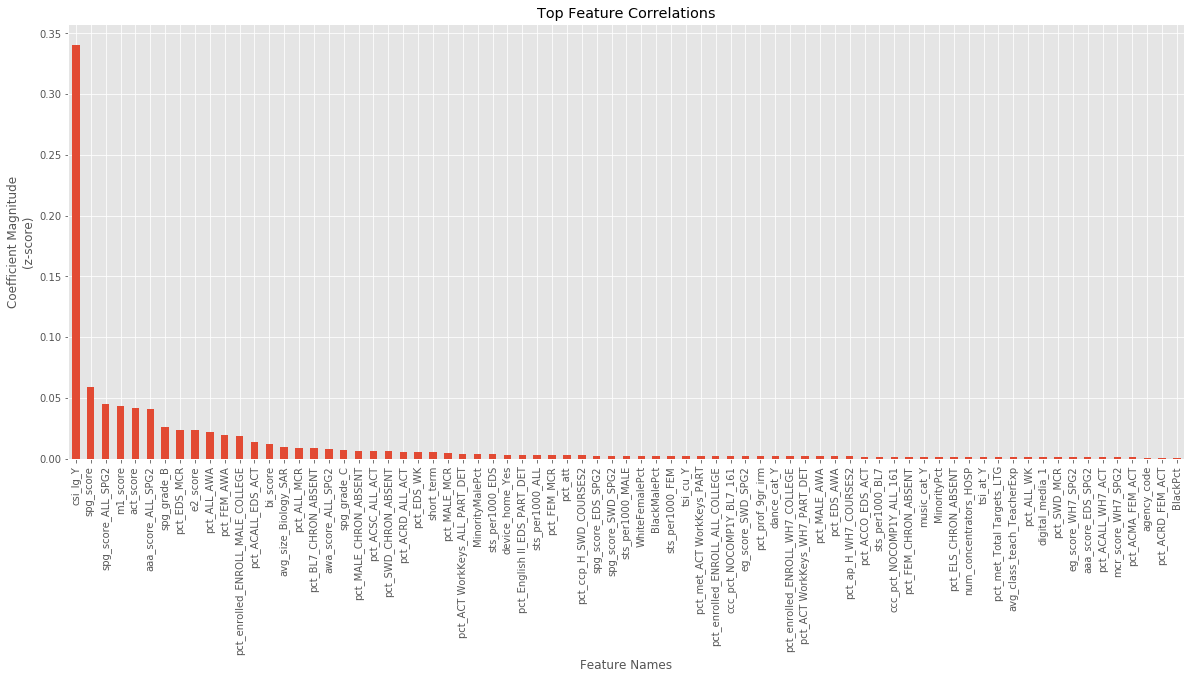

In [27]:
# Examine categorical variables of interest  
import matplotlib.pyplot as plt
%matplotlib inline

#Plot the model's feature importances
# REFERENCE:  Eric Larson, https://github.com/eclarson/DataMiningNotebooks
plt.style.use('ggplot')

wt_plt_df = linreg_ft_imp_df.head(75)

weights = pd.Series(wt_plt_df['weights'].values,index=wt_plt_df['feature_names'])
ax = weights.plot(kind='bar', figsize=(20,8))

ax.set_title("Top Feature Correlations")
ax.set_ylabel("Coefficient Magnitude\n(z-score)")
ax.set_xlabel("Feature Names")
plt.show()